In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [63]:
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [64]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df_train=pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
df_test = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')
df_train.head()

Class Index  \
0            3   
1            3   
2            3   
3            3   
4            3   

                                                                       Title  \
0                          Wall St. Bears Claw Back Into the Black (Reuters)   
1                        Carlyle Looks Toward Commercial Aerospace (Reuters)   
2                            Oil and Economy Cloud Stocks' Outlook (Reuters)   
3               Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)   
4  Oil prices soar to all-time record, posing new menace to US economy (AFP)   

                                                                                                                                                                                               Description  
0                                                                                                           Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.  
1  Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another p...  
2                 Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.  
3      Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.  
4                                         AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

In [66]:
df_train['text'] = df_train['Title']+" "+df_train['Description']
df_train['target'] = df_train['Class Index']
df_train.head()
df = df_train

In [67]:
# 分层抽样字典定义 组名：数据个数
typicalNDict = {4: 3000, 3: 3000, 2: 3000, 1: 3000}
 
# 函数定义
def typicalsamling(group, typicalNDict):
    name = group.name
    n = typicalNDict[name]
    return group.sample(n=n)


In [68]:
df = df.groupby('target').apply(typicalsamling, typicalNDict)
print(df['target'].value_counts())

target
1    3000
2    3000
3    3000
4    3000
Name: count, dtype: int64


# Clean data

In [69]:
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    # 这里我将短字符筛选去掉了；因为新闻用语比较规范，没必要
#     # removing stop-words
#     text = [word for word in text.split() if word not in list(STOPWORDS)]
    
#     # word lemmatization
#     sentence = []
#     for word in text:
#         lemmatizer = WordNetLemmatizer()
#         sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return text

In [70]:
df['tidy_text'] = df['text'].apply(datacleaning)
df.loc[:,['tidy_text','text']].head(10)

tidy_text  \
target                                                                                                                                                                                                                  
1      32319  wonder woman  a mideast version  finds her niche cairo  jalila finally tracked down the terrorists who stole plutonium from the nuclear power plant where she worked they had set up a camp right ou...   
       70370  drive to nab last german nazis to begin in january reuters reuters  the nazihunting simon wiesenthal centerwill begin a campaign in january to flush out the lastsurviving nazi war criminals in ger...   
       25847                                                                   australians kidnapped in iraq australia is investigating reports that two of its citizens have been taken hostage by militants in iraq   
       62352  senior house republican in reelection war ap ap  having served  terms illinois rep phil crane is the most senior republican in the house his quest for an th is proving difficult and has party stra...   
       36921  investors to weigh selloff earnings new york  investors on thursday will weigh the sharp retraction in stocks the day before as well as fears that the corporate profit picture is deteriorating dow...   
       57855                                                                  seven die in japan suicide pact mass suicide is suspected after japanese police find seven people dead in a van in mountains near tokyo   
       83366  france dispatches more troops to ivory coast reuters reuters  france has ordered more troops to ivorycoast to protect french citizens after nine french soldiers anda us aid worker were killed in a...   
       69685  eu to give  mln for au force in darfursolana reuters reuters  eu foreign policy chief javiersolana said on saturday the european union and its memberstates would contribute more than  million to a...   
       27486           at least  killed in iraq attacks the worst attack was a car bomb explosion outside a police training center in baghdad at least  people mostly new recruits were killed and more than  wounded   
       18421  six dead in iraq blasts six people were killed and eight others wounded saturday when a car bomb and remote bomb exploded simultaneously next to an iraqi police academy in kirkuk an iraqi national...   

                                                                                                                                                                                                                 text  
target                                                                                                                                                                                                                 
1      32319  Wonder Woman -- a Mideast version -- finds her niche CAIRO -- Jalila finally tracked down the terrorists who stole plutonium from the nuclear power plant where she worked. They had set up a camp r...  
       70370  Drive to Nab Last German Nazis to Begin in January (Reuters) Reuters - The Nazi-hunting Simon Wiesenthal Center\will begin a campaign in January to flush out the last\surviving Nazi war criminals ...  
       25847                                                               Australians 'kidnapped' in Iraq Australia is investigating reports that two of its citizens have been taken hostage by  militants in Iraq.  
       62352  Senior House Republican in Re-Election War (AP) AP - Having served 17 terms, Illinois Rep. Phil Crane is the most senior Republican in the House. His quest for an 18th is proving difficult and has...  
       36921  Investors to Weigh Sell-Off, Earnings NEW YORK - Investors on Thursday will weigh the sharp retraction in stocks the day before as well as fears that the corporate profit picture is deteriorating....  
       57855                                                               Seven die in

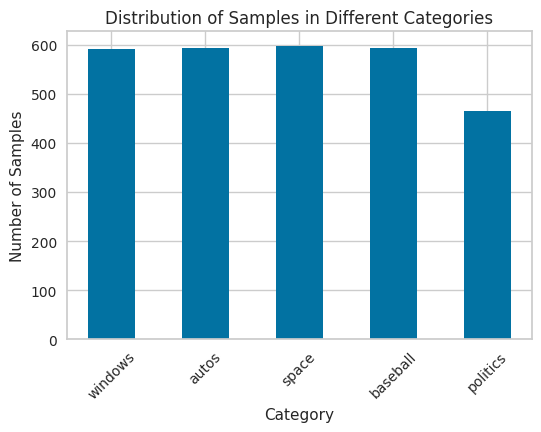

In [71]:
import matplotlib.pyplot as plt

# 数据准备
categories = ['windows', 'autos', 'space', 'baseball', 'politics']
counts = [591, 594, 597, 593, 465]

# 绘制条形图
plt.figure(figsize=(6, 4))
plt.bar(categories, counts, width=0.5)  # width参数控制柱子的宽度
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Different Categories')
plt.xticks(rotation=45)
plt.show()

In [72]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95, stop_words='english')
X = vectorizer.fit_transform(df['tidy_text']).toarray()

# train

In [73]:
def kmeans_eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)

    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

In [74]:
def hierarchical_eval_cluster(embedding):
    y_pred = hierarchical.fit_predict(embedding)

    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

In [75]:
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    df[f'x0_{method}'] = x0
    df[f'x1_{method}'] = x1

In [76]:
def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + KMeans 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

# Doc2vec

In [77]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
import gensim, logging
import os
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec,Word2Vec
import gensim.models.doc2vec

In [78]:
def add_label(twt):
    output = []
    for i, s in enumerate(df['tidy_text']):
        output.append(TaggedDocument(s.split(), ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(df['tidy_text']) # label all the tweets

In [79]:
labeled_tweets[:6]

[TaggedDocument(words=['wonder', 'woman', 'a', 'mideast', 'version', 'finds', 'her', 'niche', 'cairo', 'jalila', 'finally', 'tracked', 'down', 'the', 'terrorists', 'who', 'stole', 'plutonium', 'from', 'the', 'nuclear', 'power', 'plant', 'where', 'she', 'worked', 'they', 'had', 'set', 'up', 'a', 'camp', 'right', 'outside', 'her', 'native', 'city', 'of', 'all', 'faiths', 'and', 'were', 'clearly', 'up', 'to', 'no', 'good'], tags=['tweet_0']),
 TaggedDocument(words=['drive', 'to', 'nab', 'last', 'german', 'nazis', 'to', 'begin', 'in', 'january', 'reuters', 'reuters', 'the', 'nazihunting', 'simon', 'wiesenthal', 'centerwill', 'begin', 'a', 'campaign', 'in', 'january', 'to', 'flush', 'out', 'the', 'lastsurviving', 'nazi', 'war', 'criminals', 'in', 'germany', 'the', 'head', 'of', 'thecenters', 'jerusalem', 'office', 'said', 'sunday'], tags=['tweet_1']),
 TaggedDocument(words=['australians', 'kidnapped', 'in', 'iraq', 'australia', 'is', 'investigating', 'reports', 'that', 'two', 'of', 'its', '

In [80]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=1000, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(X), epochs=25)
# model_d2v=gensim.models.Doc2Vec.load('my_model.model')

100%|██████████| 12000/12000 [00:00<00:00, 1255873.64it/s]


CPU times: user 2min 5s, sys: 19.7 s, total: 2min 25s
Wall time: 1min 12s


In [81]:
model_d2v.save('my_model.model')

In [82]:
tokenized_tweet = df['tidy_text'].apply(lambda x: x.split()) # tokenizing 

docvec_arrays = np.zeros((len(tokenized_tweet), 1000)) 
for i in range(len(df['tidy_text'])):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,1000))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(12000, 1000)

In [83]:
docvec_arrays[:6,:10]

array([[-0.2172917 ,  0.01093943,  0.24083073,  0.45975038, -0.17006634,
         0.64817083,  0.13928998,  0.20660724, -0.05072386, -0.55661643],
       [-0.4205845 , -0.06592499,  0.27005345,  0.087844  ,  0.21652326,
        -0.14300346,  0.01614103,  0.25197011,  0.40517944,  0.05053658],
       [ 0.02969302,  0.18193817,  0.09156328,  0.29179356,  0.21050566,
         0.09522077,  0.14839897,  0.28083342, -0.5236361 , -0.19328278],
       [-0.01775474, -0.10737323, -0.12906313,  0.42922071,  0.41570041,
        -0.15714726, -0.05676616, -0.57597864,  0.01066501,  0.33222929],
       [ 0.49452531,  0.03728103, -0.41332814,  0.56220561,  0.55710834,
        -0.06315962,  0.25234675, -0.33942875,  0.09296309,  0.21852197],
       [-0.22290088, -0.05047683,  0.28508314,  0.3572987 , -0.01500615,
        -0.4853633 ,  0.79038042,  0.19430132, -0.33907938, -0.30322549]])

# 肘图确定簇类个数

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

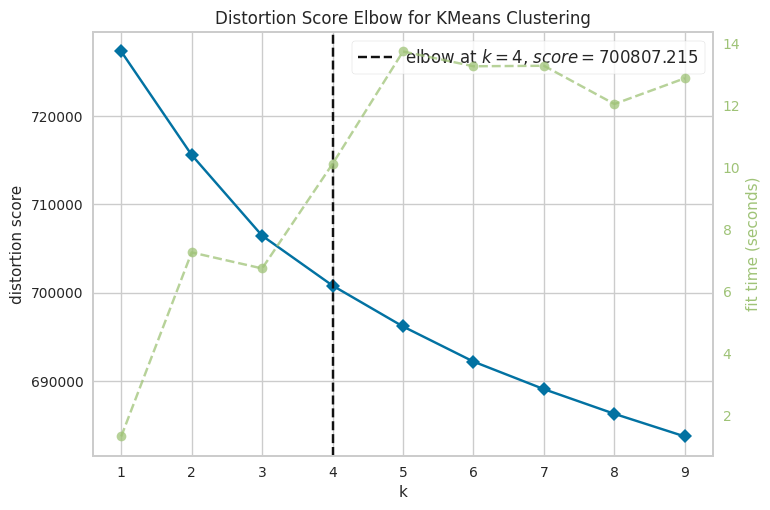

最佳的K值是4
elbow_score_值是700807.2153211448


In [84]:
import pandas as pd
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer


# datafile= r"../../ML_data/iris.csv"
# data_df = pd.read_csv(datafile,header =0)

# X = data_df[["sepal_length","sepal_width","petal_length","petal_width"]]

oz = kelbow_visualizer(KMeans(random_state=1), docvec_df, k=(1,10))
k = oz.elbow_value_
print(f"最佳的K值是{k}")
print(f"elbow_score_值是{oz.elbow_score_}")

# Sentence Transformer

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
df['encode_transforemers'] = df['tidy_text'].apply(lambda tidy_text: model.encode(tidy_text, convert_to_numpy=True).flatten())
X_transformers = np.vstack(df['encode_transforemers'])

In [97]:
X_transformers.shape

(12000, 384)

# 训练和测试

In [98]:
def kmeans_eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)

    # 计算 NMI, and FMI
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)
    # 计算轮廓系数
    silhouette_avg = silhouette_score(embedding, y_pred)
    # 计算Davies-Bouldin指数
    db_index = davies_bouldin_score(embedding, y_pred)

    # Print Metrics scores
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))
    print("Silhouette Score: {:.3f}".format(silhouette_avg))
    print("Davies-Bouldin Index: {:.3f}".format(db_index))

In [99]:
from sklearn.metrics import silhouette_score, davies_bouldin_score


def hierarchical_eval_cluster(embedding):
    y_pred = hierarchical.fit_predict(embedding)
    #y_pred = spectral.fit_predict(embedding)

    # 计算 NMI, and FMI
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)
    # 计算轮廓系数
    silhouette_avg = silhouette_score(embedding, y_pred)
    # 计算Davies-Bouldin指数
    db_index = davies_bouldin_score(embedding, y_pred)

    # Print Metrics scores
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))
    print("Silhouette Score: {:.3f}".format(silhouette_avg))
    print("Davies-Bouldin Index: {:.3f}".format(db_index))

In [100]:
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    df[f'x0_{method}'] = x0
    df[f'x1_{method}'] = x1

In [101]:
def plot_pca_kmeans(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"KMeans 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_pca_kmeans_true(x0_name, x1_name, method):
    plt.figure(figsize=(12, 7))

    plt.title(f"20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    # 使用真实标签作为颜色
    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue="target", palette="viridis")
    plt.show()

In [103]:
def plot_pca_hierarchical(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"Hierarchical 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

# Kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-p

Normalized Mutual Information (NMI): 0.274
Fowlkes-Mallows Index (FMI): 0.459
Silhouette Score: 0.003
Davies-Bouldin Index: 12.717
predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


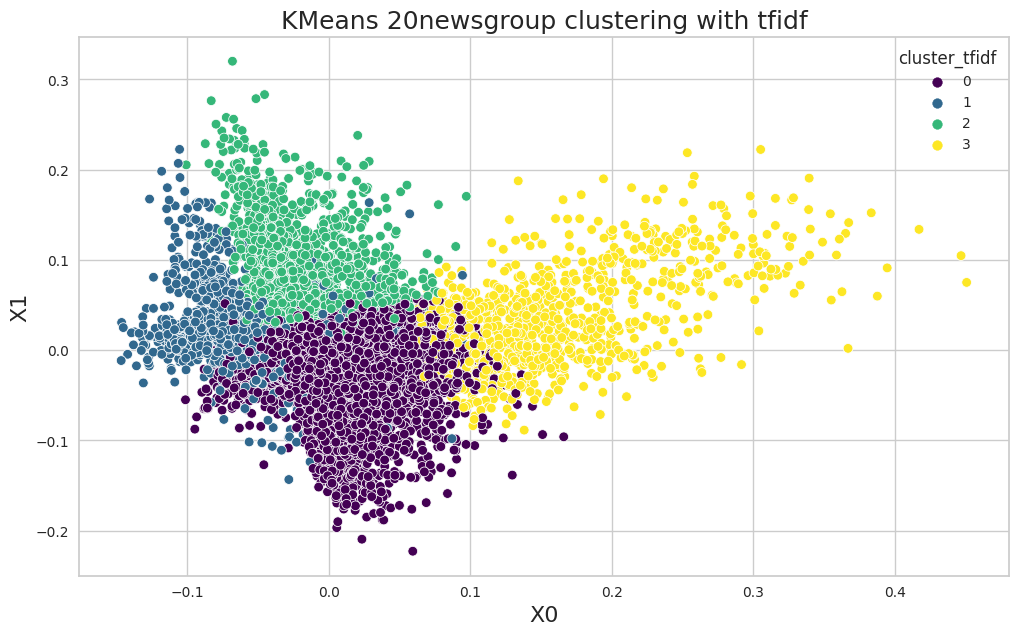

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


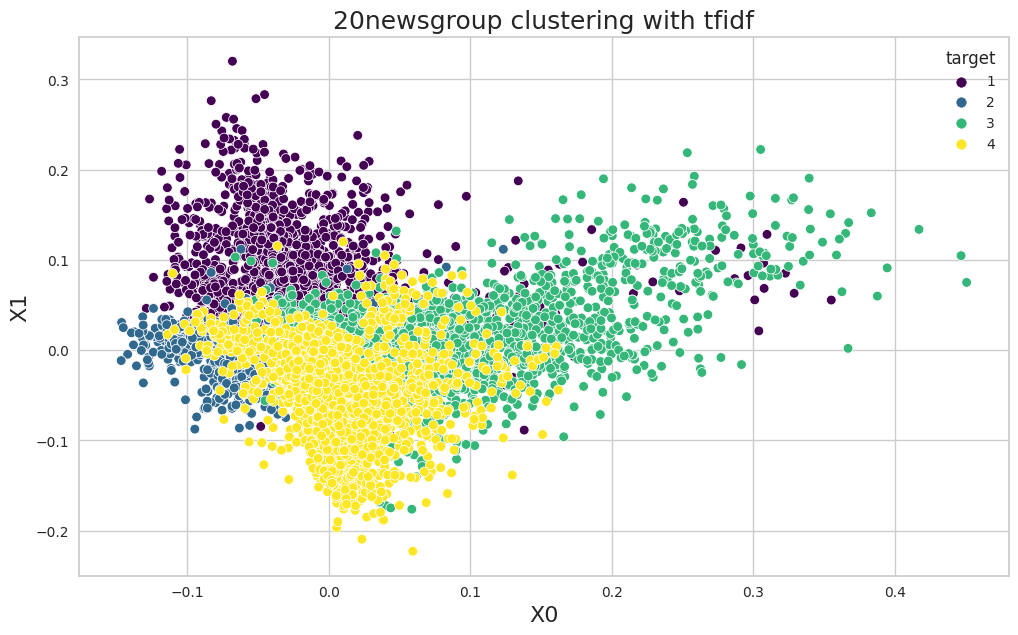

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

Normalized Mutual Information (NMI): 0.310
Fowlkes-Mallows Index (FMI): 0.494
Silhouette Score: 0.013
Davies-Bouldin Index: 6.410


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


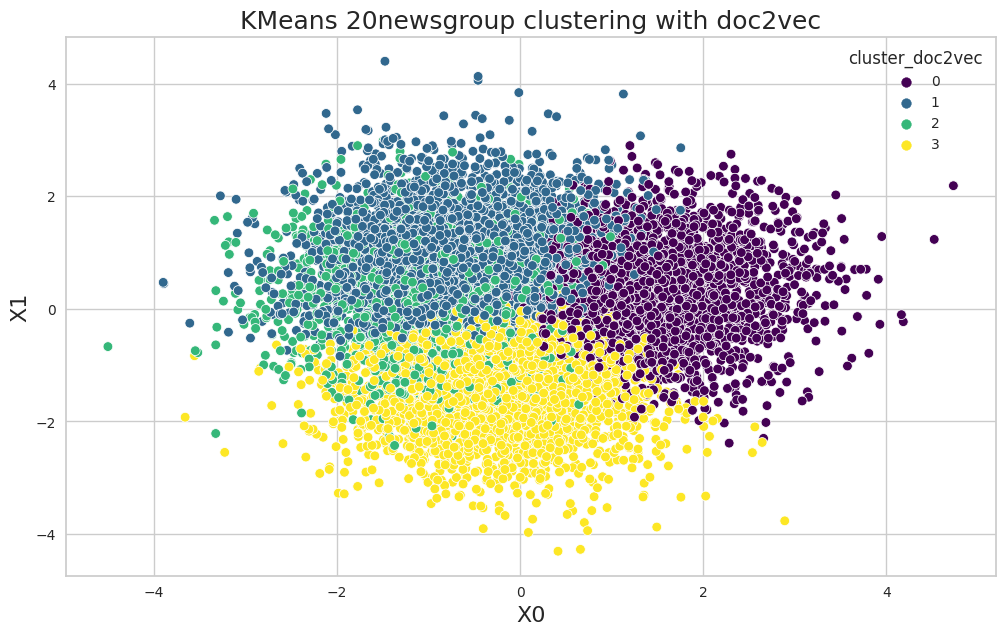

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


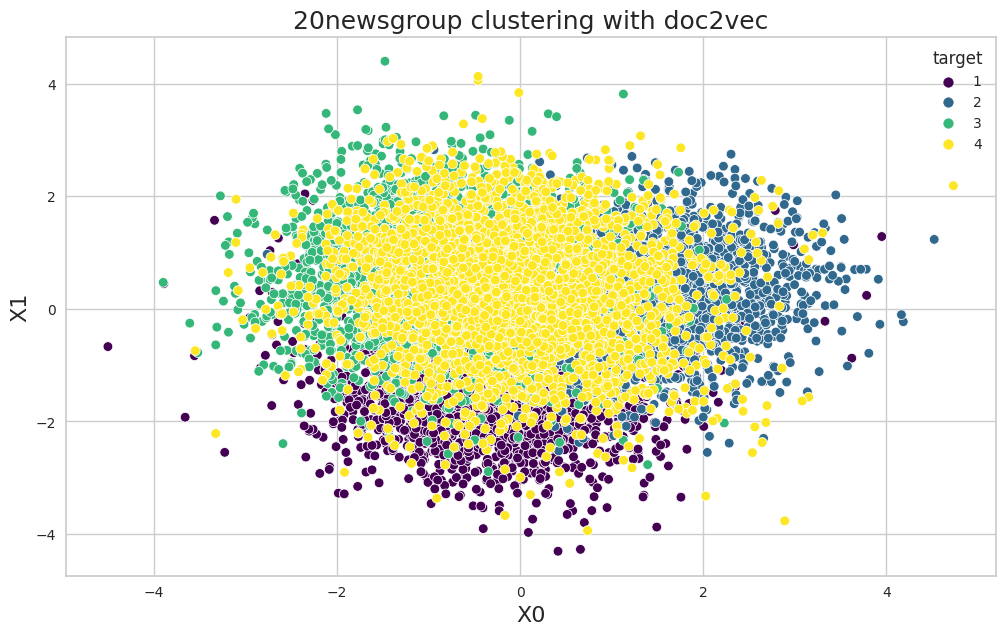

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-p

Normalized Mutual Information (NMI): 0.604
Fowlkes-Mallows Index (FMI): 0.730
Silhouette Score: 0.035
Davies-Bouldin Index: 4.898
predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


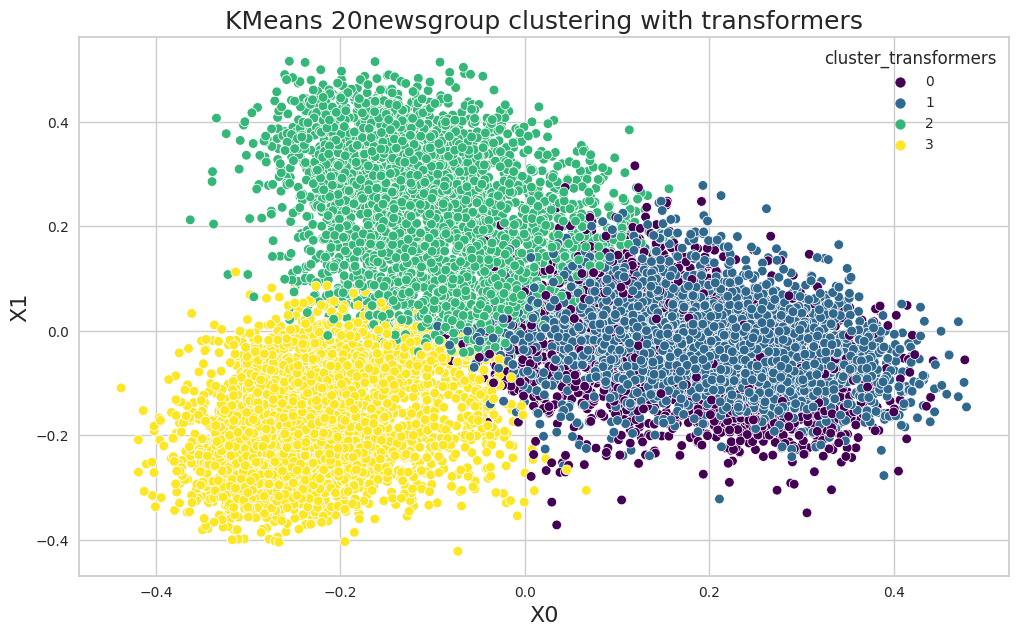

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


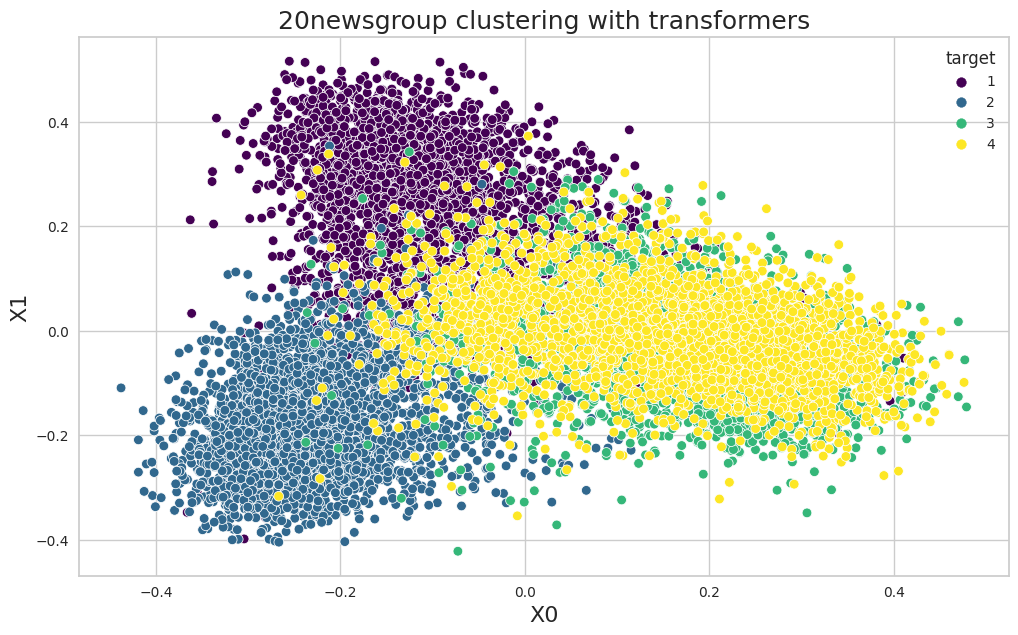

In [104]:
for embedding_and_method in [(X, 'tfidf'), (docvec_df, 'doc2vec'), (X_transformers, 'transformers')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=4, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters

    kmeans_eval_cluster(embedding)

    dimension_reduction(embedding, method)
    print('predict:')
    plot_pca_kmeans(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)
    print('true')
    plot_pca_kmeans_true(f'x0_{method}', f'x1_{method}',method)

# Kmeans++

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-p

Normalized Mutual Information (NMI): 0.274
Fowlkes-Mallows Index (FMI): 0.459
Silhouette Score: 0.003
Davies-Bouldin Index: 12.717
predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


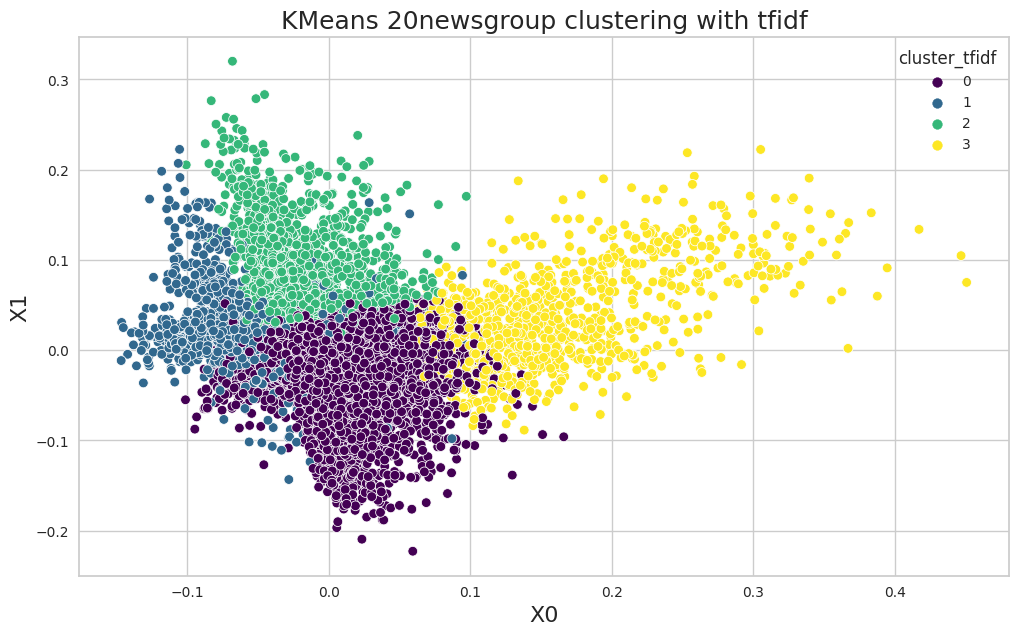

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


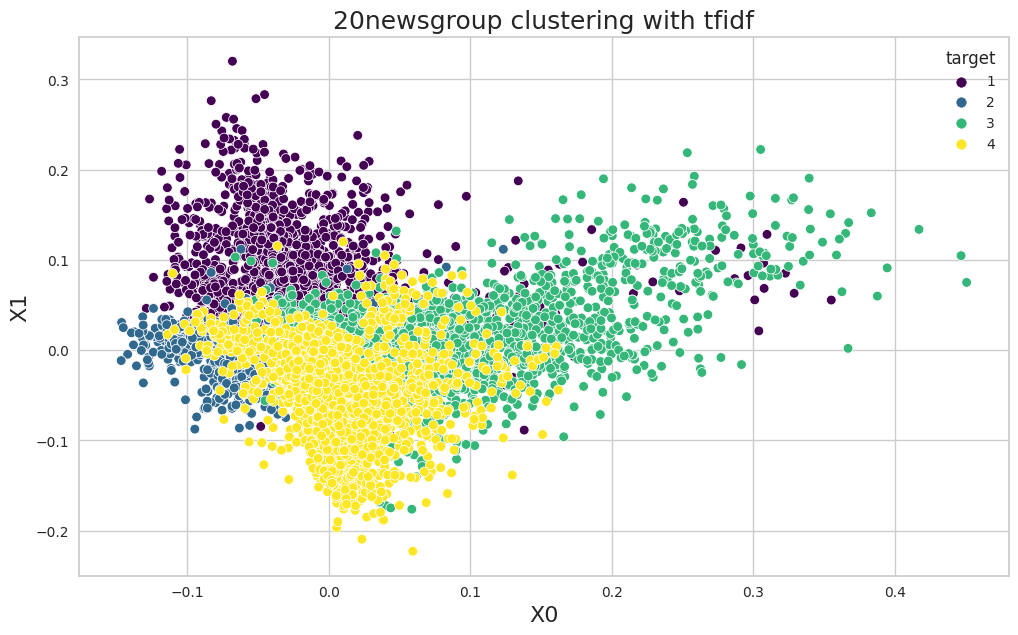

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

Normalized Mutual Information (NMI): 0.310
Fowlkes-Mallows Index (FMI): 0.494
Silhouette Score: 0.013
Davies-Bouldin Index: 6.410


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


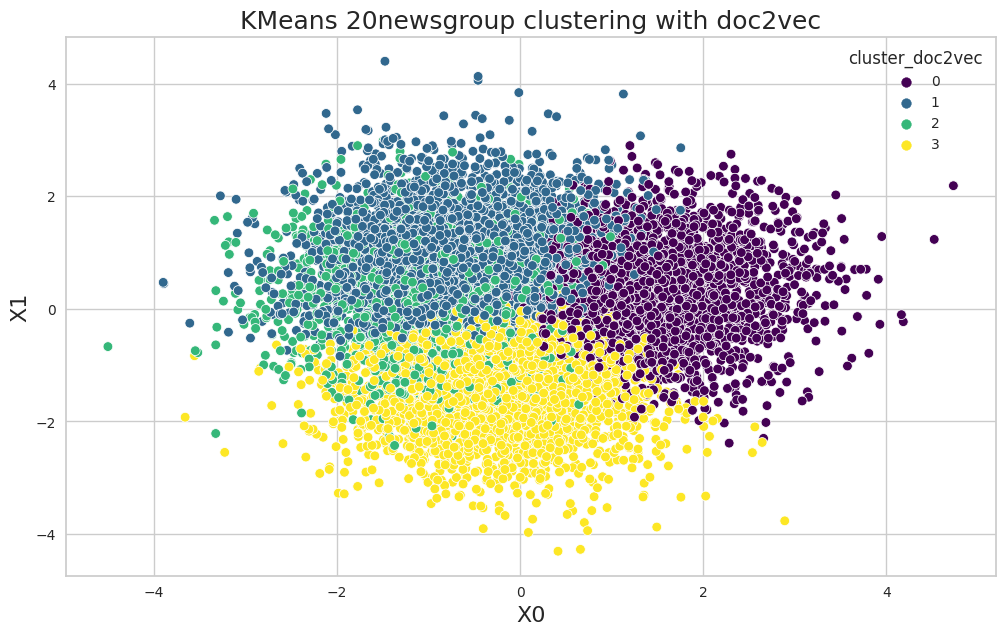

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


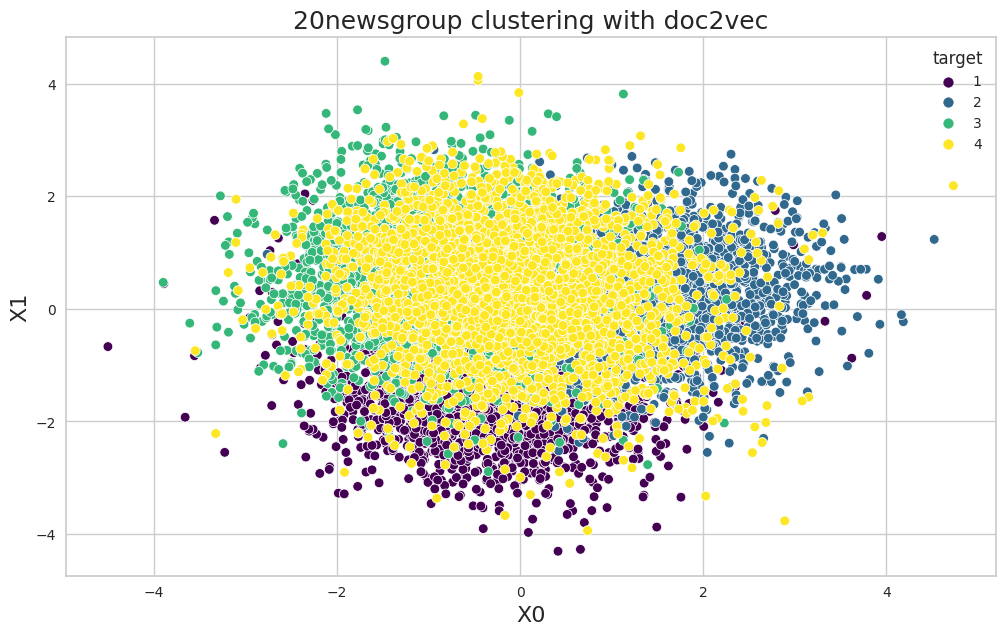

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-p

Normalized Mutual Information (NMI): 0.604
Fowlkes-Mallows Index (FMI): 0.730
Silhouette Score: 0.035
Davies-Bouldin Index: 4.898
predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


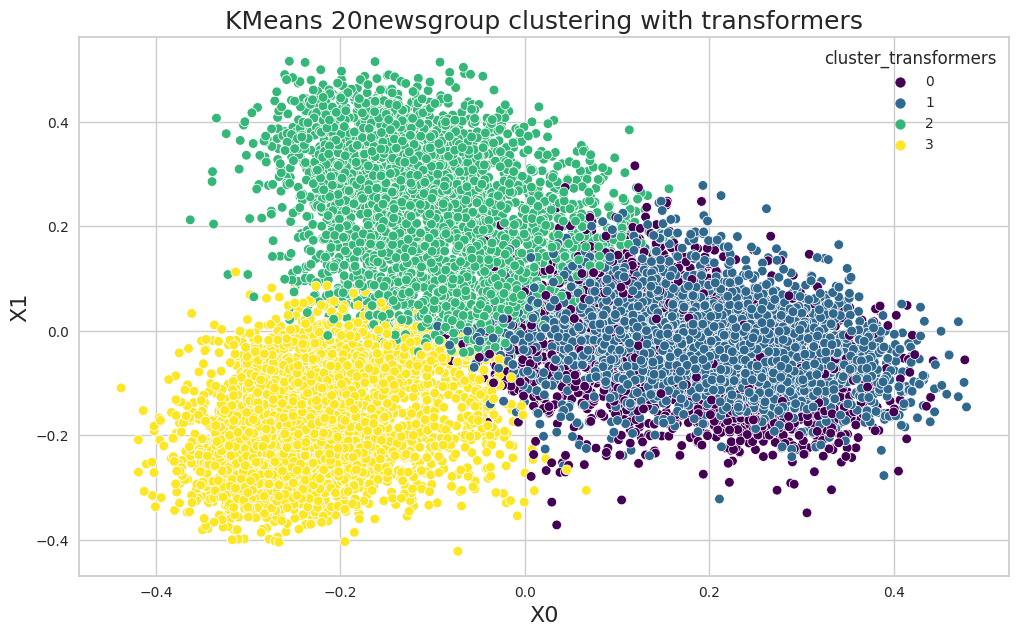

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


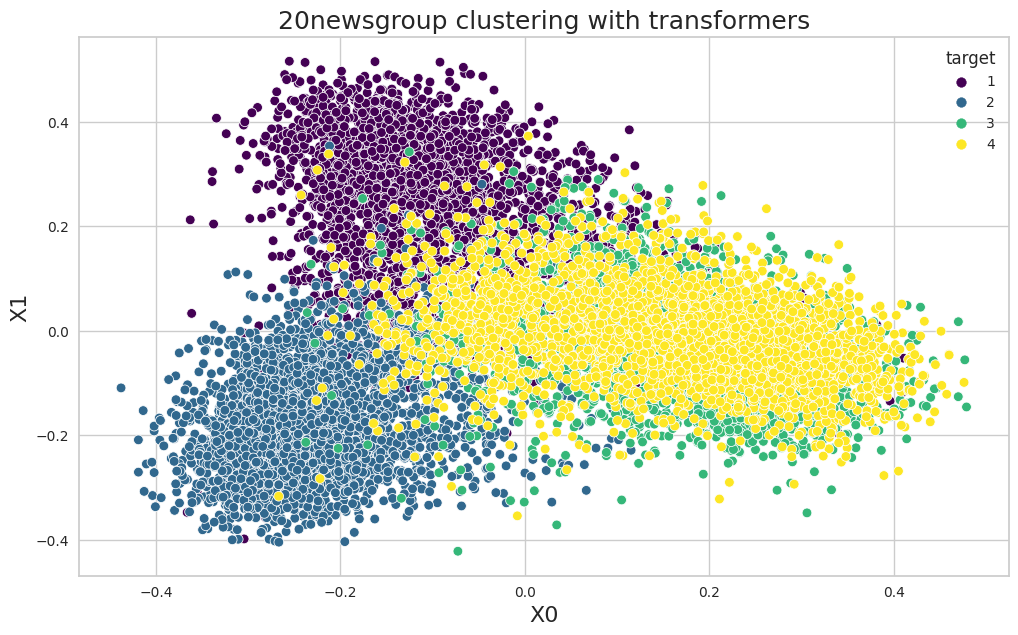

In [105]:
for embedding_and_method in [(X, 'tfidf'), (docvec_df, 'doc2vec'), (X_transformers, 'transformers')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters

    kmeans_eval_cluster(embedding)

    dimension_reduction(embedding, method)
    print('predict:')
    plot_pca_kmeans(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)
    print('true')
    plot_pca_kmeans_true(f'x0_{method}', f'x1_{method}',method)


# Bi-Kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Normalized Mutual Information (NMI): 0.315
Fowlkes-Mallows Index (FMI): 0.491
Silhouette Score: 0.003
Davies-Bouldin Index: 15.801
predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


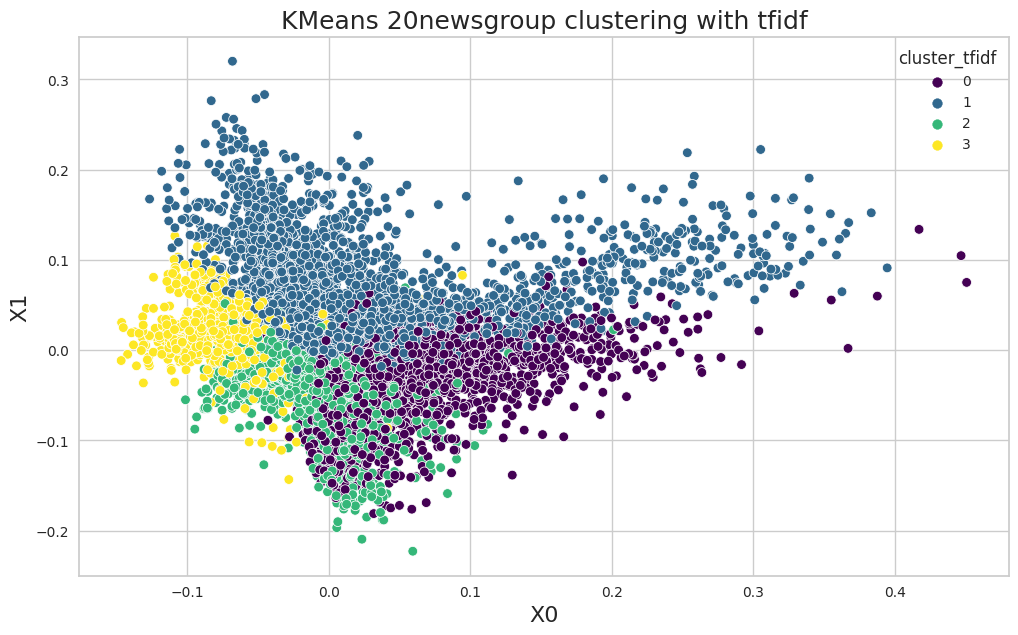

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


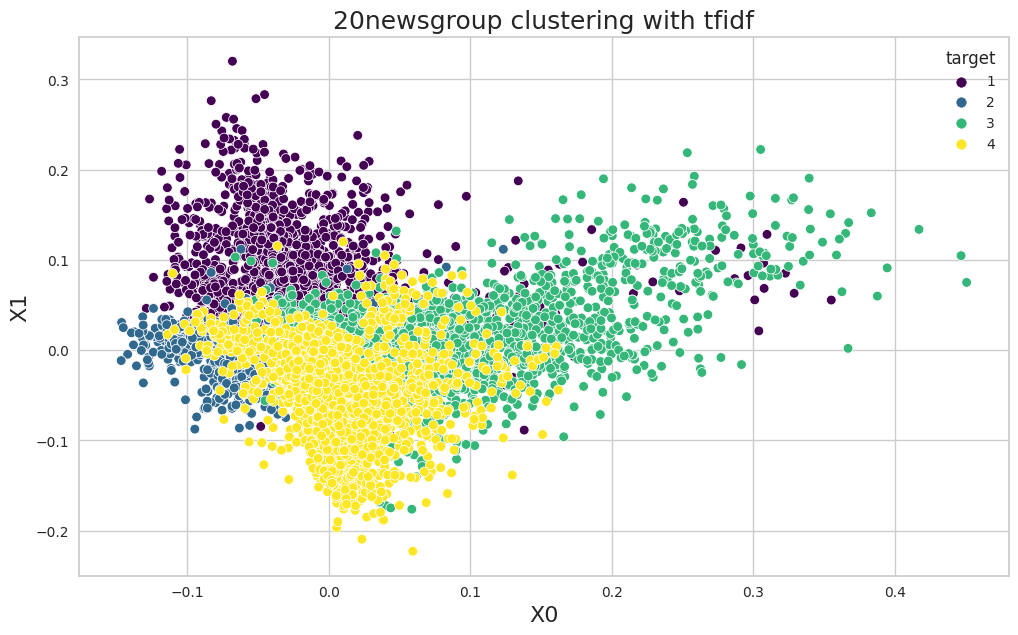

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

Normalized Mutual Information (NMI): 0.266
Fowlkes-Mallows Index (FMI): 0.446
Silhouette Score: 0.010
Davies-Bouldin Index: 7.405


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


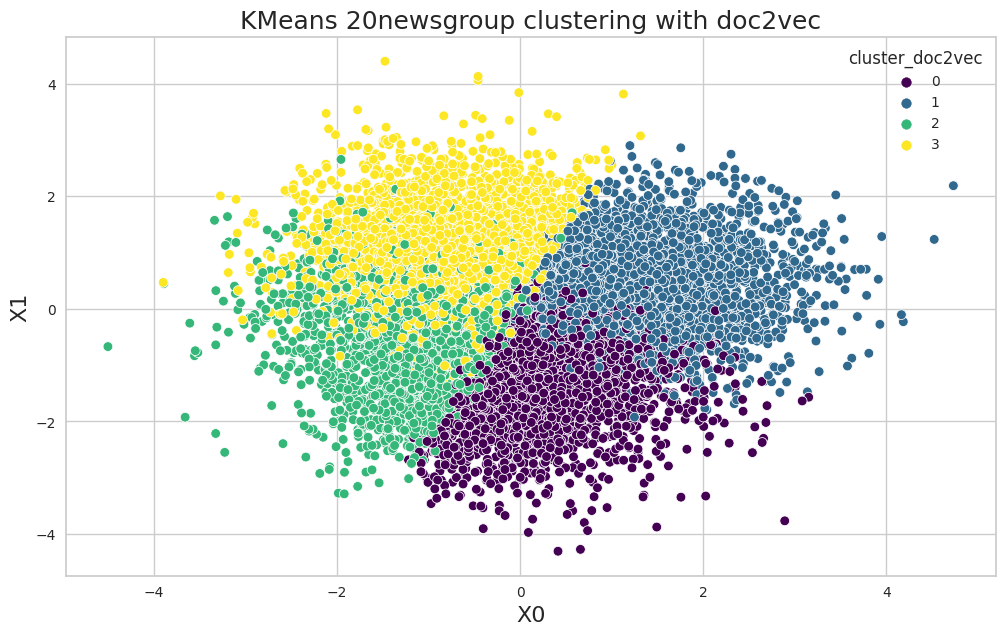

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


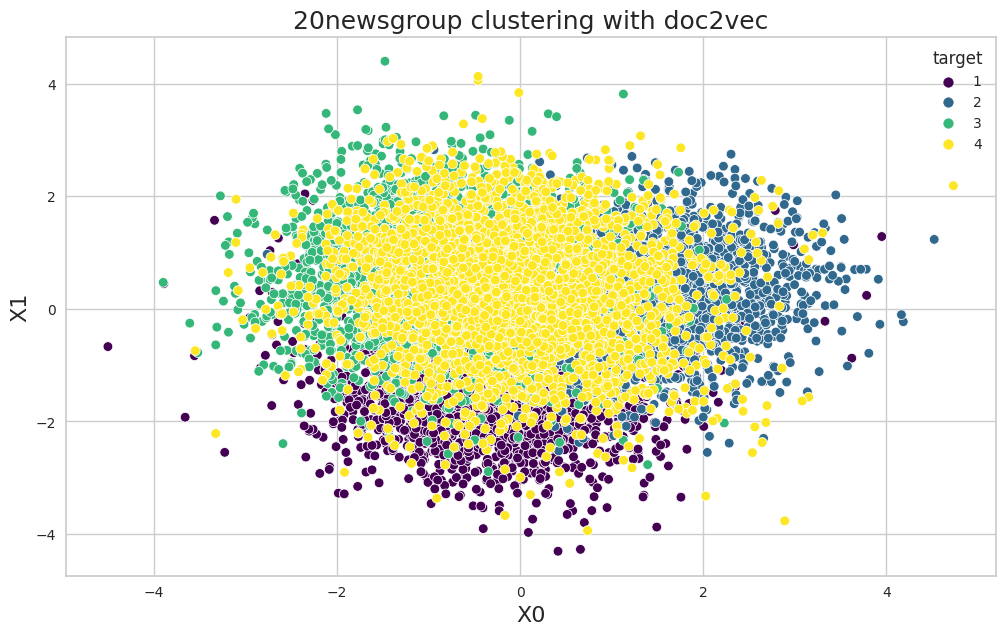

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Normalized Mutual Information (NMI): 0.565
Fowlkes-Mallows Index (FMI): 0.697
Silhouette Score: 0.034
Davies-Bouldin Index: 4.979
predict:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


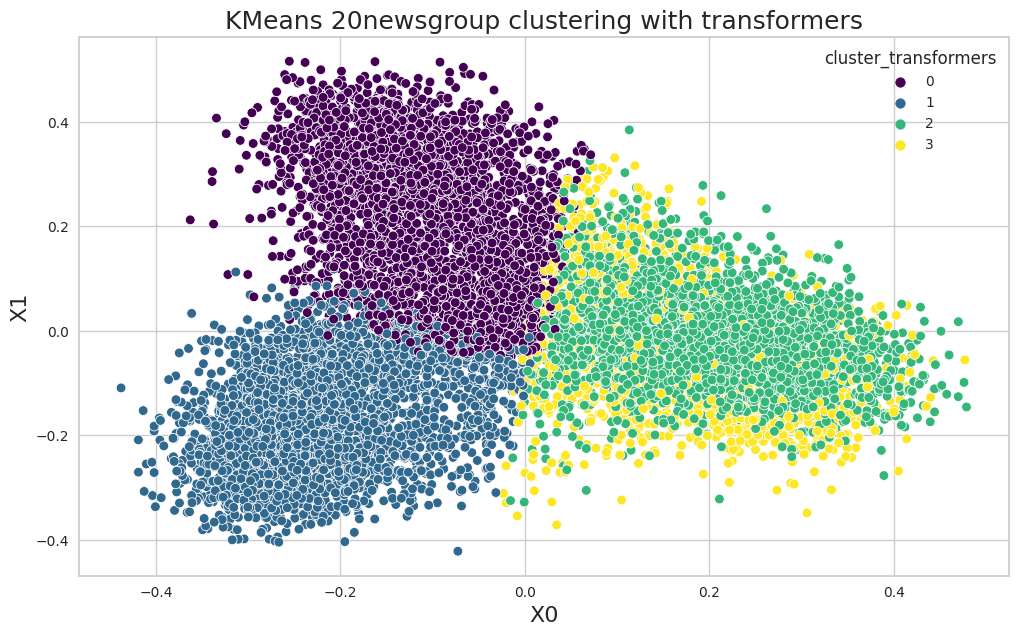

true


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


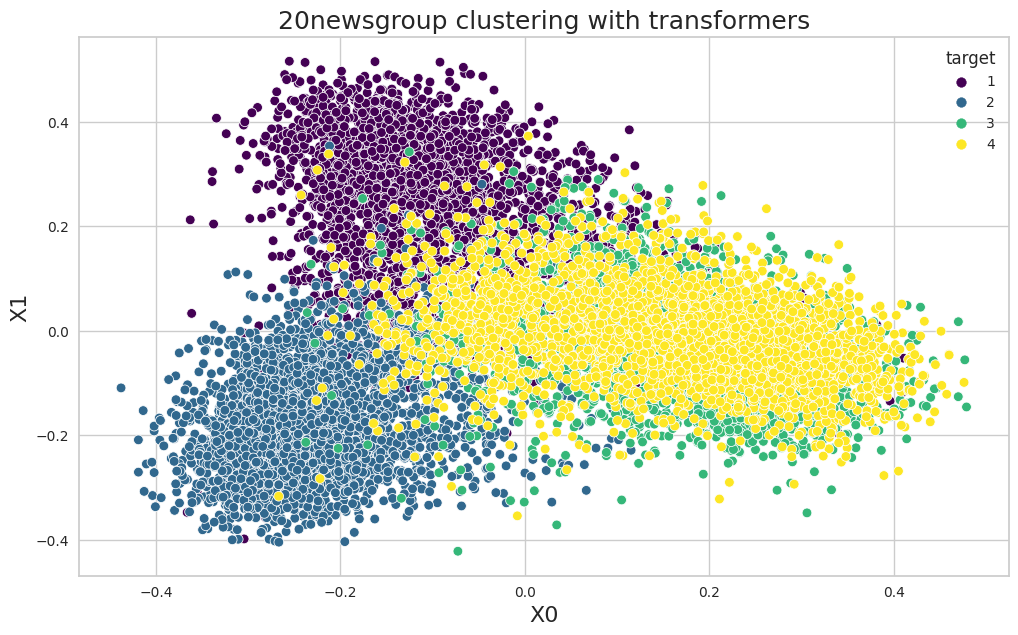

In [106]:
for embedding_and_method in [(X, 'tfidf'), (docvec_df, 'doc2vec'), (X_transformers, 'transformers')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = BisectingKMeans(n_clusters=4, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters

    kmeans_eval_cluster(embedding)

    dimension_reduction(embedding, method)
    print('predict:')
    plot_pca_kmeans(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)
    print('true')
    plot_pca_kmeans_true(f'x0_{method}', f'x1_{method}',method)
    
    

In [ ]:
#!pip install yellowbrick